In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Dropout, Reshape
from keras.layers import Conv1D, Flatten, AveragePooling1D, MaxPooling1D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

Using TensorFlow backend.


In [2]:
credit_df = pd.read_csv('./dataset.csv')
credit_df.columns

Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

Check the distribution of each  variable

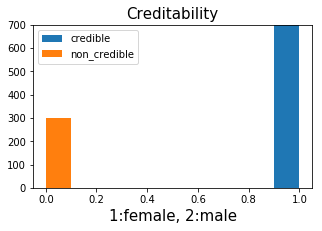

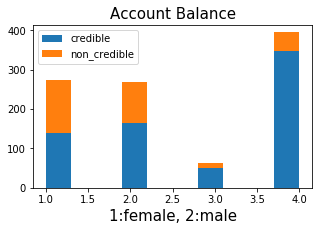

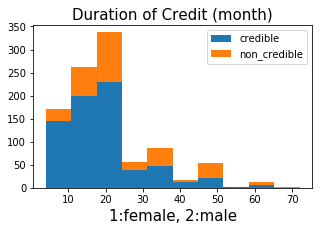

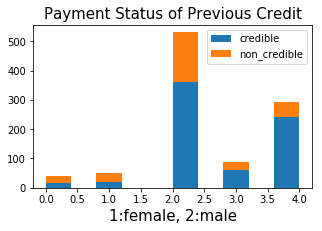

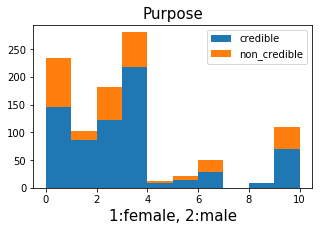

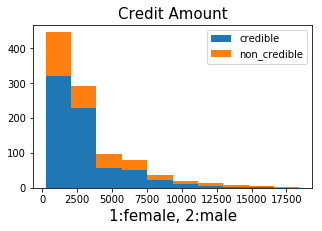

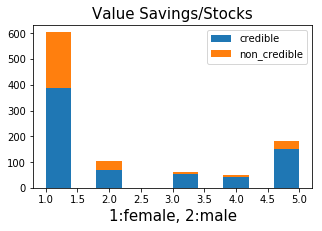

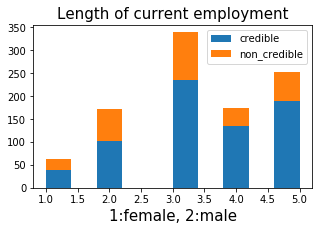

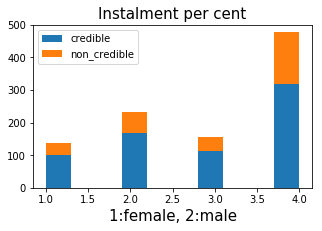

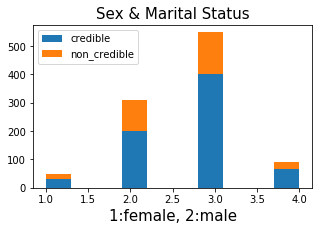

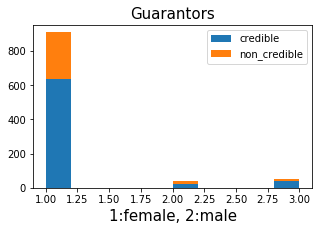

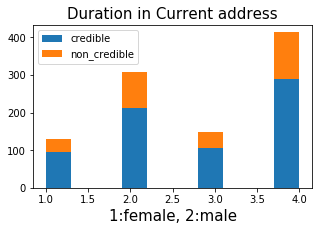

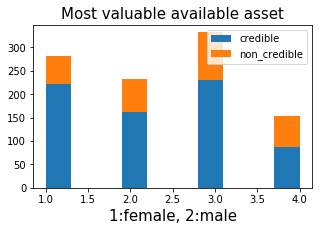

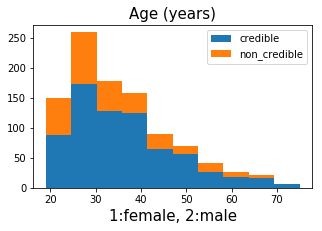

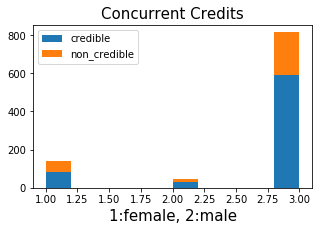

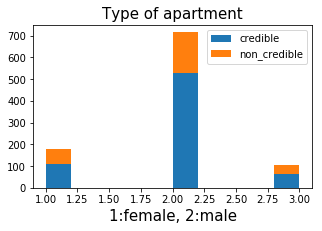

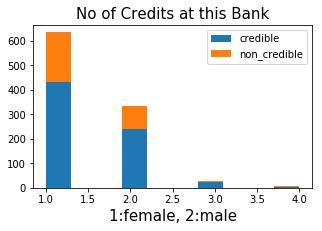

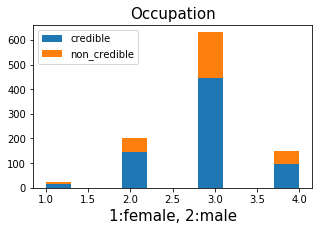

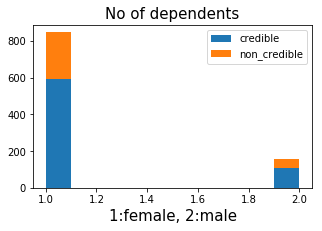

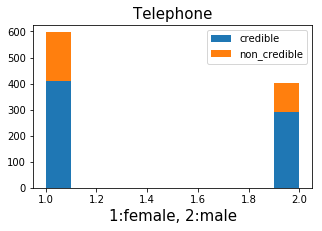

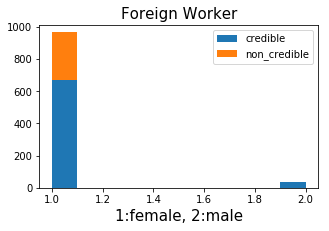

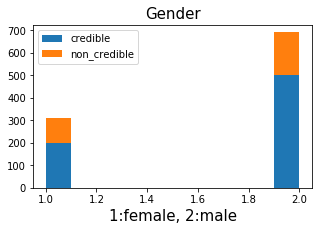

In [4]:
male_idx = (credit_df['Sex & Marital Status']==1) | (credit_df['Sex & Marital Status']==3) | \
                 (credit_df['Sex & Marital Status']==4)
female_idx = (credit_df['Sex & Marital Status']==2) | (credit_df['Sex & Marital Status']==5)
male = credit_df[male_idx]
female = credit_df[female_idx]

# insert a column of gender, 1 female, 2 female
credit_df.insert(loc=len(credit_df.columns), column='Gender', value=1)
credit_df.loc[male_idx, 'Gender'] = 2

credible = credit_df[credit_df['Creditability']==1]
non_credible = credit_df[credit_df['Creditability']==0]

for col in credit_df.columns: 
    fig = plt.gcf()
    fig.set_size_inches(5,3)
    plt.hist([credible[col], non_credible[col]], stacked=True, label=['credible', 'non_credible'])
    plt.title(col, fontsize=15)
    plt.xlabel('1:female, 2:male', fontsize=15)
#     plt.xlabel('0:bad creditability, 1:good creditability', fontsize=15)
#     plt.xlabel('1:foreign worker, 1:native worker', fontsize=15)
#     plt.xlabel('1 : unemployed/ unskilled - non-resident; 2 : unskilled - resident; \n3 : skilled employee / official; 4 : management/ self-employed/ highly qualified employee/ officer ')
    plt.legend()
    plt.show()
#     credit_df[col].plot(kind='hist')
#     plt.show()

In [5]:
male.shape, female.shape, len(male)/len(credit_df), len(female)/len(credit_df)

((690, 21), (310, 21), 0.69, 0.31)

Show the explainable discrimination in historical data

In [59]:
male_idx = (credit_df['Sex & Marital Status']==1) | (credit_df['Sex & Marital Status']==3) | \
                 (credit_df['Sex & Marital Status']==4)
female_idx = (credit_df['Sex & Marital Status']==2) | (credit_df['Sex & Marital Status']==5)
male = credit_df[male_idx]
female = credit_df[female_idx]
credible = credit_df[credit_df['Creditability']==1]
credible_male = credit_df[(credit_df['Creditability']==1) & male_idx]
credible_female = credit_df[(credit_df['Creditability']==1) & female_idx]
male.shape, female.shape, credible.shape, credible_male.shape, credible_female.shape
print('%.2f%% of the credible is male, while %.2f%% is female'  % \
          (100*credible_male.shape[0]/credible.shape[0], 100*credible_female.shape[0]/credible.shape[0]))
print('ratio of credible for male and female: %.2f%%, %.2f%%'  % \
          (100*credible_male.shape[0]/male.shape[0], 100*credible_female.shape[0]/female.shape[0]))

71.29% of the credible is male, while 28.71% is female
ratio of credible for male and female: 72.32%, 64.84%


In [60]:
foreign_idx = (credit_df['Foreign Worker']==1)
native_idx = (credit_df['Foreign Worker']==2)
foreign = credit_df[foreign_idx]
native = credit_df[native_idx]
credible = credit_df[credit_df['Creditability']==1]
credible_foreign = credit_df[(credit_df['Creditability']==1) & foreign_idx]
credible_native = credit_df[(credit_df['Creditability']==1) & native_idx]
male.shape, female.shape, credible.shape, credible_male.shape, credible_female.shape
print('%.2f%% of the credible is foreign workers, while %.2f%% is native'  % \
          (100*credible_foreign.shape[0]/credible.shape[0], 100*credible_native.shape[0]/credible.shape[0]))
print('ratio of credible for foreign and native: %.2f%%, %.2f%%'  % \
          (100*credible_foreign.shape[0]/foreign.shape[0], 100*credible_native.shape[0]/native.shape[0]))
foreign.shape, native.shape

95.29% of the credible is foreign workers, while 4.71% is native
ratio of credible for foreign and native: 69.26%, 89.19%


((963, 21), (37, 21))

In [61]:
def get_model():
    # create model
    model = Sequential()
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Test the model performance with different sets of vairables used for training the model

In [63]:
all_var = credit_df.columns[1:]
legal = credit_df.columns[ [1, 3, 5, 6, 8, 10, 12, 14, 16 ] ]
maybe = credit_df.columns[ [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17 ] ]
feature_groups = {'all variables':all_var, 'legal variables':legal, 'maybe OK variables':maybe}

# shuffle rows of the dataframe
credit_df = credit_df.sample(frac=1).reset_index(drop=True)

for k, v in feature_groups.items():
    X = credit_df[v].values
    Y = credit_df['Creditability'].values

    seed = 4
    estimators = []
    # estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=get_model, epochs=10, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
#     kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    results = cross_val_score(pipeline, X, Y, cv=10,  scoring='f1')
    print(k+': ')
    print("%.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

all variables: 
82.36% (3.00%)
legal variables: 
82.14% (3.07%)
maybe OK variables: 
82.26% (3.03%)
